# Application of CNN-UNET for Image Reconstruction Optimization in Continuous Wave Diffuse Optical Tomography System

## Import Library

In [23]:
import os
import re
import time
import datetime
import glob
import math
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Input, Lambda, Dense
from sklearn.model_selection import train_test_split
from keras.saving import register_keras_serializable
import tensorflow.keras.backend as K

## Pre-processing

## Fungsi

#### Metric Dice Coefficient

In [25]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

## Model

#### Dataset

##### Load Data Intensitas

In [ ]:
intensitas = np.load('/CWDOT/data/x.npy')

In [17]:
intensitas.shape

(5604, 16, 16)

##### Load Data Gambar Objek Asli

In [ ]:
ori = np.load('/CWDOT/data/y.npy')

In [19]:
ori.shape

(5604, 64, 64)

#### Arsitektur

In [ ]:
def cnn(input_shape=(16, 16, 1)):

    inputs = layers.Input(shape=input_shape)
    # === ENCODER ===
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # === BOTTLENECK ===
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # === DECODER ===
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # === LAPISAN OUTPUT ===
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs, name='ModelA')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss='binary_crossentropy',
                   metrics=[dice_coefficient, 'mae'])

    return model

model_A = cnn()
model_A.summary()

Model: "ModelA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 16, 16,    │      2,560 │ input_layer_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_33[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 16, 16,    │    524,544 │ conv2d_36[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │  1,179,904 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_37[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 32, 32,    │    131,200 │ conv2d_38[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_transpose… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_39[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 64, 64,    │     32,832 │ conv2d_40[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_transpose… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_41[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64, 1) │         65 │ conv2d_42[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,960,257 (26.55 MB)

 Trainable params: 6,960,257 (26.55 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [34]:
x_train, x_test, y_train, y_test = train_test_split(intensitas,ori,test_size=0.2,shuffle=True,random_state=42)

In [35]:
cnn_stat = model_A.fit(x_train,y_train,epochs=25,batch_size=8,validation_data=(x_test,y_test))

Epoch 1/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - dice_coefficient: 0.7233 - loss: 0.3272 - mae: 0.1801 - val_dice_coefficient: 0.8899 - val_loss: 0.1614 - val_mae: 0.0549
Epoch 2/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - dice_coefficient: 0.8910 - loss: 0.1585 - mae: 0.0554 - val_dice_coefficient: 0.9050 - val_loss: 0.1407 - val_mae: 0.0464
Epoch 3/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - dice_coefficient: 0.9058 - loss: 0.1368 - mae: 0.0456 - val_dice_coefficient: 0.9178 - val_loss: 0.1247 - val_mae: 0.0355
Epoch 4/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - dice_coefficient: 0.9160 - loss: 0.1237 - mae: 0.0372 - val_dice_coefficient: 0.9229 - val_loss: 0.1168 - val_mae: 0.0317
Epoch 5/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - dice_coefficient: 0.9222 - loss: 0.1154 - mae: 0.0319 - val_dice_coefficient: 0.9297 - val_loss: 0.1089 - val_mae: 0.0267
Epoch 6/25
561/561 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - dice_coefficient: 0.9263 - loss: 0.1097 - mae: 0.0288 

#### Test

In [36]:
y_pred_cnn = model_A.predict(x_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


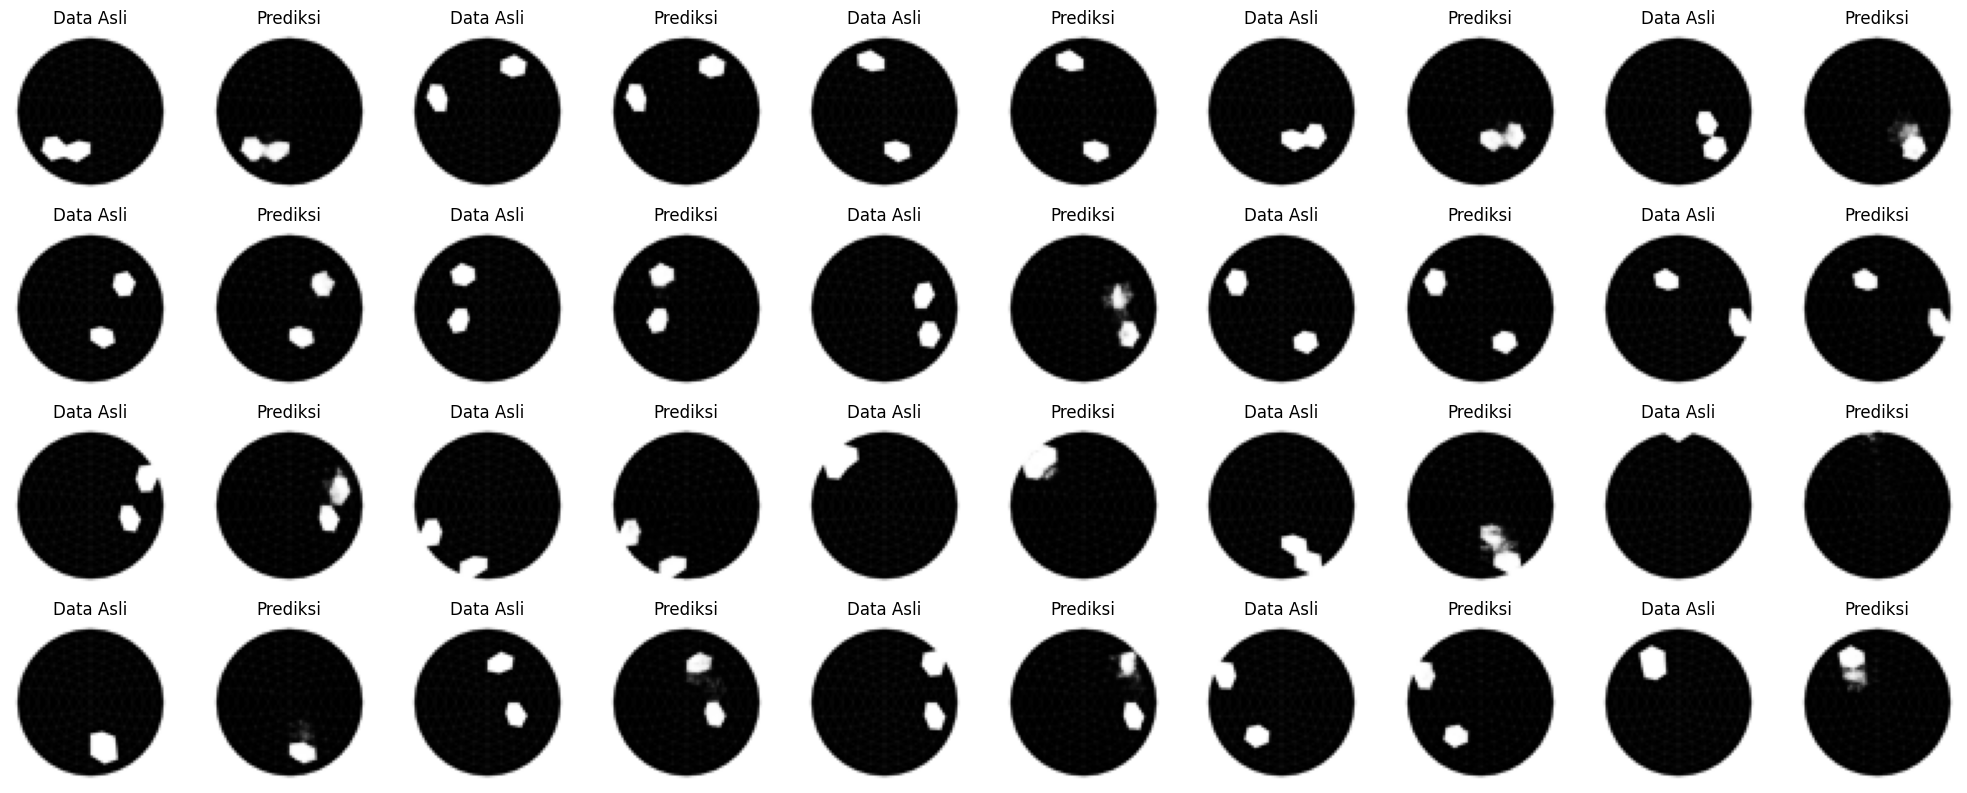

In [58]:
num_images = 20

indices = np.random.choice(len(y_pred_cnn), num_images, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    # Ground Truth
    plt.subplot(5, 10, 2 * i + 1)
    plt.imshow(y_test[idx], cmap='gray')
    plt.title("Data Asli")
    plt.axis("off")

    # Prediction
    plt.subplot(5, 10, 2 * i + 2)
    plt.imshow(y_pred_cnn[idx], cmap='gray')
    plt.title("Prediksi")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Save Model

In [43]:
model_A.save('MODEL.keras')

In [ ]:
model_history = pd.DataFrame(cnn_stat.history)
model_history.to_excel('training_history.xlsx', index=False)

#### Loss & Akurasi

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(modelA_stat['loss'], label='Training Loss')
plt.plot(modelA_stat['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Kurva Loss')
plt.legend()

# # Plot MAE
plt.subplot(1, 3, 2)
plt.plot(modelA_stat['mae'], label='Training MAE')
plt.plot(modelA_stat['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Kurva MAE')
plt.legend()

# # Plot ssim_metric
plt.subplot(1, 3, 3)
plt.plot(modelA_stat['dice_coefficient'], label='Training SSIM')
plt.plot(modelA_stat['val_dice_coefficient'], label='Validation SSIM')
plt.xlabel('Epoch')
plt.ylabel('DSC')
plt.title('Kurva DSC')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

